In [64]:
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from tqdm import tqdm
import time


import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

In [21]:
glob('*.csv')

['insurance.csv']

In [59]:
# Seed 고정

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [33]:
data = pd.read_csv('insurance.csv',encoding='utf-8')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
# Null Check

data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

- Not Null

In [14]:
#sex
le = LabelEncoder()
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)
# smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)
#region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)

In [18]:
data.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

<AxesSubplot: >

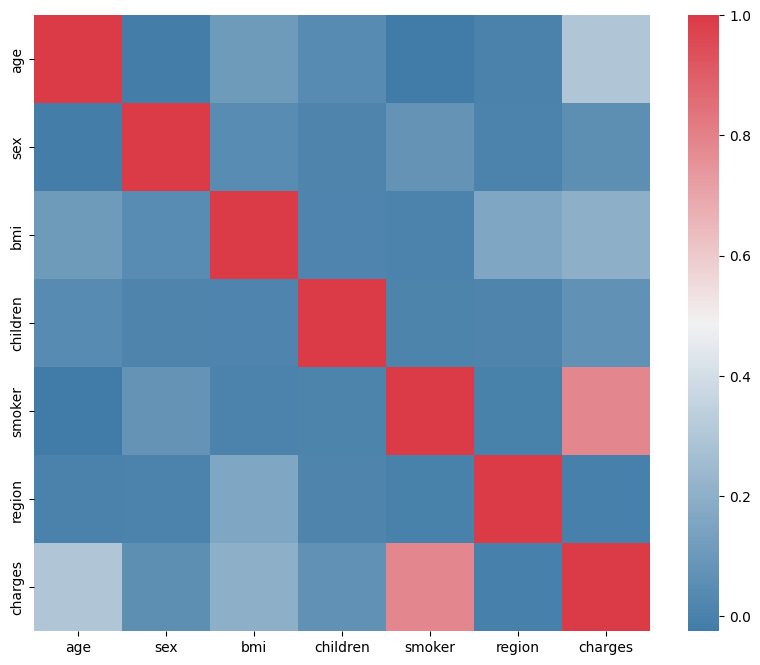

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

## corr 높은 순으로 분석

In [35]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


(array([ 30., 127., 234., 319., 288., 195.,  96.,  32.,  14.,   3.]),
 array([15.96 , 19.677, 23.394, 27.111, 30.828, 34.545, 38.262, 41.979,
        45.696, 49.413, 53.13 ]),
 <BarContainer object of 10 artists>)

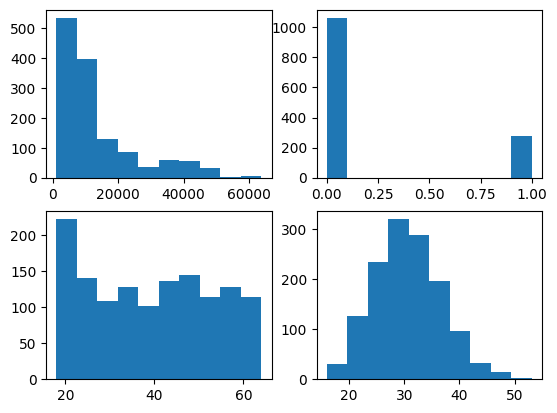

In [46]:
fig, axes = plt.subplots(2,2)
axes[0,0].hist(data['charges'])
axes[0,1].hist(data['smoker'])
axes[1,0].hist(data['age'])
axes[1,1].hist(data['bmi'])

In [71]:
def eda(col1 : str, col2 : str):
    data.groupby([col2, col1])[['charges']].mean()
    smoker_grouped = data.groupby([col1, col2])
    smoker_group_mean_charges = smoker_grouped['charges'].mean().unstack()
    smoker_group_mean_charges.plot(kind='bar')
    plt.xlabel(col1)
    plt.ylabel('Mean Charges')
    plt.title(f'Mean Medical Charges by {col1} Group and {col2} Status')
    plt.show()

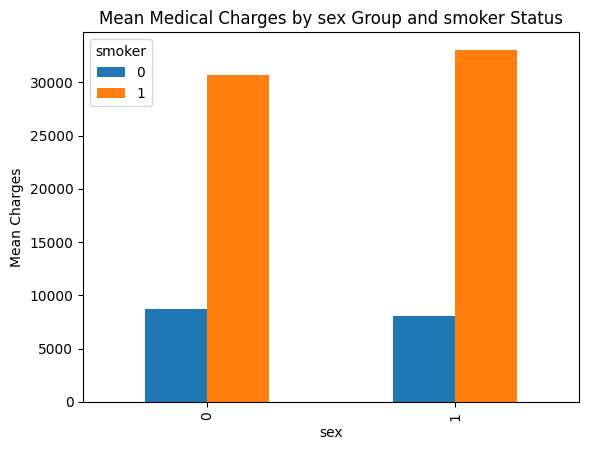

In [72]:
eda('sex','smoker')

In [24]:
# 흡연 여부에 따른 연령대의 진료비 청구금액 평균 비교를 위해 연령대 그룹화

data['age_group'] = pd.cut(data['age'], bins=[0, 19, 29, 39, 49, 59, np.inf], labels=['10s', '20s', '30s', '40s', '50s', '60s+'])

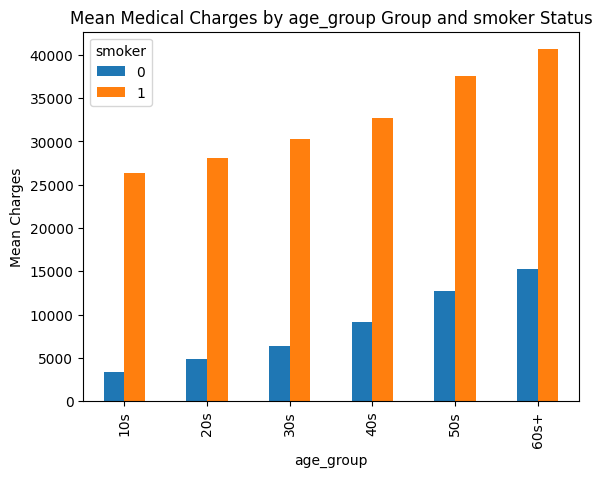

In [73]:
eda('age_group','smoker')

In [23]:
# 흡연 여부에 따른 BMI별 의료비 청구금액의 평균을 구하기 위해 BMI그룹화

bins = [0, 18.5, 25, 30, 35, 40, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III']
data['bmi_group'] = pd.cut(data['bmi'], bins=bins, labels=labels)

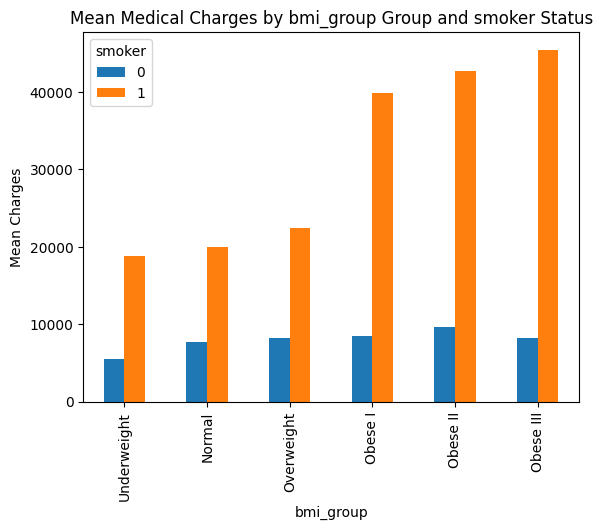

In [74]:
eda('bmi_group','smoker')

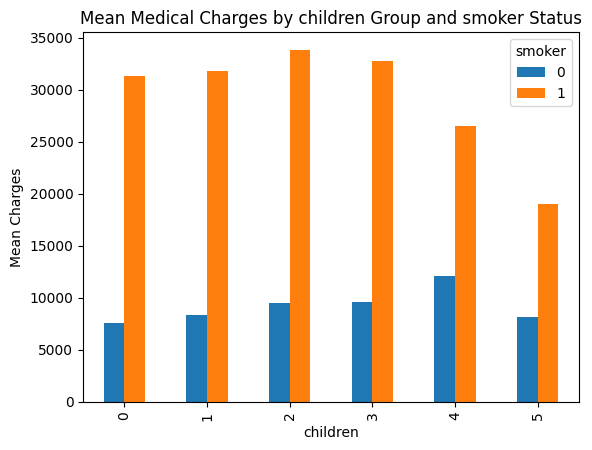

In [75]:
eda('children','smoker')

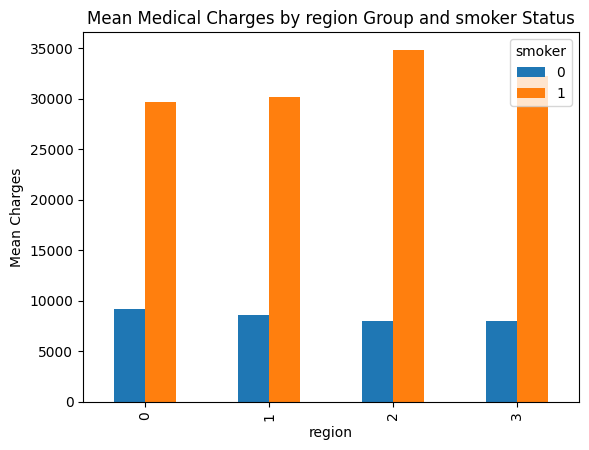

In [76]:
eda('region','smoker')

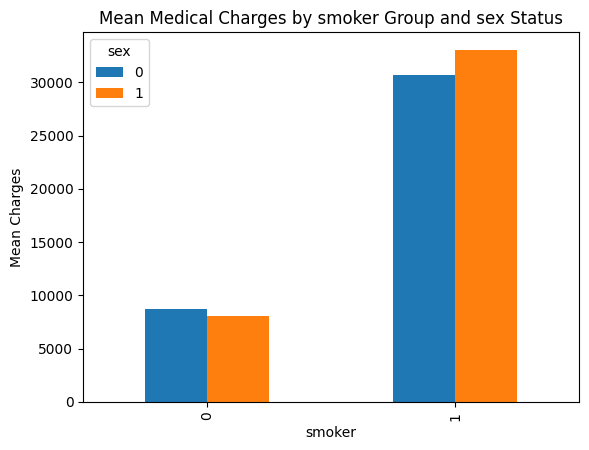

In [77]:
eda('smoker','sex')

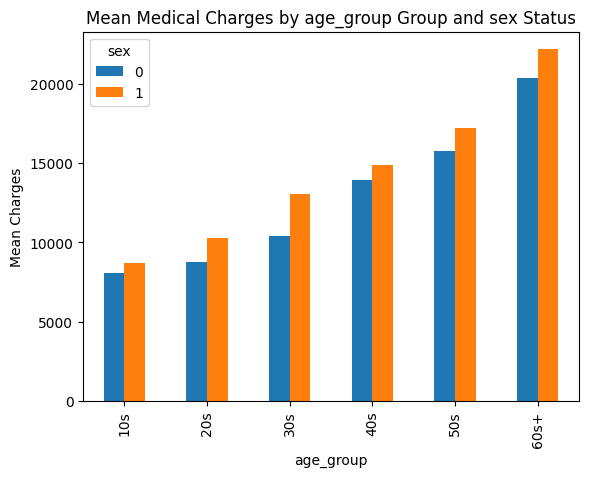

In [78]:
eda('age_group','sex')

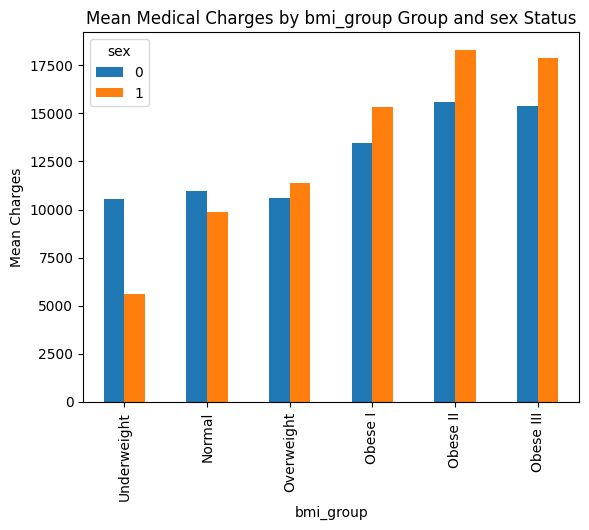

In [79]:
eda('bmi_group','sex')

### Outlier Detection

<AxesSubplot: ylabel='charges'>

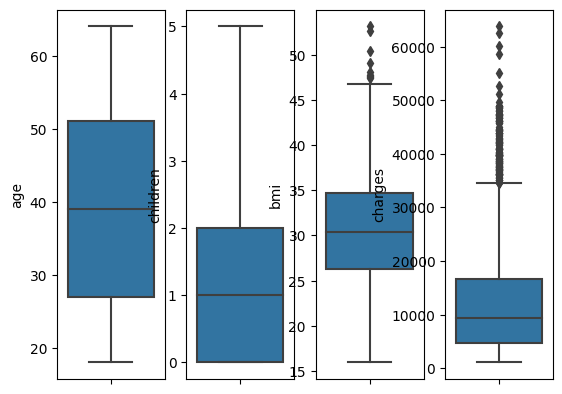

In [83]:
# 이상치 탐지를 위해 boxplot을 그려보겠습니다.
plt.subplot(1,4,1)
sns.boxplot(data=data, y='age')
plt.subplot(1,4,2)
sns.boxplot(data=data, y='children')
plt.subplot(1,4,3)
sns.boxplot(data=data, y='bmi')
plt.subplot(1,4,4)
sns.boxplot(data=data, y='charges')

In [84]:
# IQR(Q3 - Q1)로부터 이상치 파악하기
bmi_q1 = data['bmi'].quantile(q=0.25)
bmi_q3 = data['bmi'].quantile(q=0.75)
iqr = bmi_q3 - bmi_q1

# (q1 - (iqr * 1.5))와 (q3 + (iqr * 1.5))를 벗어난 값이 이상치입니다.
condi1 = (data['bmi'] < (bmi_q1 - (1.5 * iqr)))
condi2 = (data['bmi'] > (bmi_q3 + (1.5 * iqr)))
outliers = data[condi1 | condi2]
outliers['bmi']

116     49.06
286     48.07
401     47.52
543     47.41
847     50.38
860     47.60
1047    52.58
1088    47.74
1317    53.13
Name: bmi, dtype: float64

<AxesSubplot: xlabel='charges', ylabel='Count'>

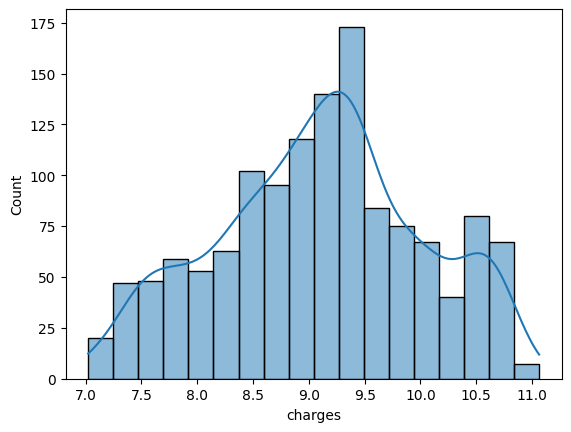

In [156]:
# 진료비 금액의 count barplot

sns.histplot(np.log(data.charges), kde=True)

<AxesSubplot: xlabel='charges', ylabel='Count'>

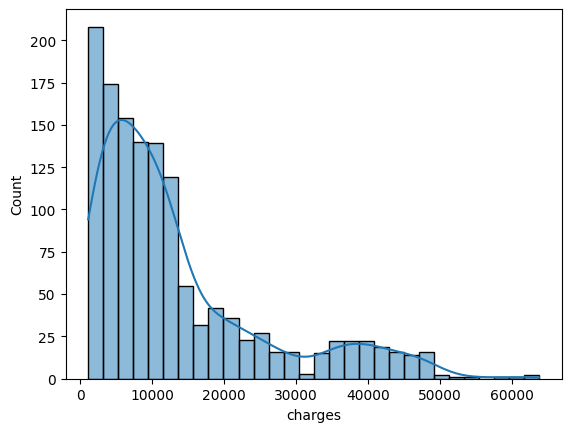

In [158]:
sns.histplot(data.charges, kde=True)

In [87]:
# resampling

from sklearn.utils import resample

results_median = []
results_mean = []

In [88]:
# 중앙값을 resampling 하여 리스트에 append

for nrepeat in range(1000):
    sample = resample(data['charges'])
    results_median.append(sample.median())

In [90]:
# 평균값을 resampling 하여 리스트에 append

for nrepeat in range(1000):
    sample = resample(data['charges'])
    results_mean.append(sample.mean())

In [91]:
# 각각의 list를 Series 형태로 변환

results_median = pd.Series(results_median)
results_mean = pd.Series(results_mean)

<AxesSubplot: ylabel='Count'>

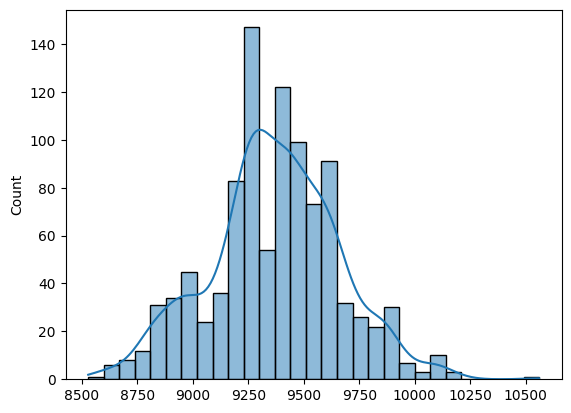

In [92]:
# resampling한 중앙값 데이터를 시각화

sns.histplot(results_median, kde=True)

In [93]:
# 범주형 변수와 수치형 변수를 분리

cat_features = data.select_dtypes(include=['object']).columns.to_list()
num_features = data.select_dtypes(exclude=['object']).columns.to_list()

In [101]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'age_group', 'bmi_group'],
      dtype='object')

In [125]:
data.head()

,age,sex,bmi,children,smoker,region,charges,age_group,bmi_group
0,19,0,27.900,0,1,3,16884.92400,10s,Overweight
1,18,1,33.770,1,0,2,1725.55230,10s,Obese I
2,28,1,33.000,3,0,2,4449.46200,20s,Obese I
3,33,1,22.705,0,0,1,21984.47061,30s,Normal
4,32,1,28.880,0,0,1,3866.85520,30s,Overweight


In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   charges   1338 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 62.8 KB


In [25]:
data = data.drop(['age_group','bmi_group','region','sex','smoker'],axis=1)

In [26]:
x = data.drop(['charges'],axis=1)

y = data['charges']

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [27]:
X_train, X_dev, y_train, y_dev = train_test_split(x,y, test_size=0.2)

In [155]:
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor()    
]

In [152]:
lst = []
for model in models:
    name = model.__class__.__name__
    model.fit(X_train,y_train)
    y_pred = model.predict(X_dev)
    mae = mean_absolute_error(y_dev, y_pred)
    print("Model %s - MAE: %.4f" %(name,mae))
    lst.append([model,mae])

Model LinearRegression - MAE: 4577.4768
Model Ridge - MAE: 4583.8766
Model Lasso - MAE: 4577.7436
Model ElasticNet - MAE: 7210.3008
Model DecisionTreeRegressor - MAE: 2918.4322
Model RandomForestRegressor - MAE: 3102.2015
Model SVR - MAE: 6757.8300
Model KNeighborsRegressor - MAE: 7657.7429
Model MLPRegressor - MAE: 7272.1786


In [60]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'age_group', 'bmi_group'],
      dtype='object')

In [169]:
data = pd.read_csv('insurance.csv',encoding='utf-8')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [40]:
# 흡연 여부에 따른 연령대의 진료비 청구금액 평균 비교를 위해 연령대 그룹화

data['age_group'] = pd.cut(data['age'], bins=[0, 19, 29, 39, 49, 59, np.inf], labels=['10s', '20s', '30s', '40s', '50s', '60s+'])

In [39]:
bins = [0, 18.5, 25, 30, 35, 40, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III']
data['bmi_group'] = pd.cut(data['bmi'], bins=bins, labels=labels)

In [29]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

In [34]:
def one_hot_encoded(df):
    ohe.fit(df.values.reshape(-1,1))
    one_hot_encoded = ohe.transform(df.values.reshape(-1,1))
    ohe_df = pd.DataFrame(one_hot_encoded, columns=ohe.categories_[0])
    return ohe_df

In [35]:
ohe_df = one_hot_encoded(data['sex'])
data = pd.concat([data,ohe_df],axis=1)

# column rename
data.rename(columns={0:'male',1:'female'},inplace=True)

In [36]:
ohe_df = one_hot_encoded(data['smoker'])
data = pd.concat([data,ohe_df],axis=1)

# column rename
data.rename(columns={0:'Non-smoke',1:'smoker'},inplace=True)

In [37]:
ohe_df = one_hot_encoded(data['region'])
data = pd.concat([data,ohe_df],axis=1)

# column rename
data.rename(columns={0:'southwest',1:'southeast',
                     2:'northwest',3:'northeast'},inplace=True)

In [41]:
ohe_df = one_hot_encoded(data['bmi_group'])
data = pd.concat([data,ohe_df],axis=1)

# column rename
data.rename(columns={0:'Overweight',1:'Obese I',2:'Normal',
                     3:'Obese II',4:'Obese III',5:'Underweight'},inplace=True)

In [42]:
ohe_df = one_hot_encoded(data['age_group'])
data = pd.concat([data,ohe_df],axis=1)

# column rename
data.rename(columns={0:'10s',1:'20s',
                     2:'30s',3:'40s',
                     4:'60s+',5:'50s'},inplace=True)

In [185]:
data.bmi_group.unique()

['Overweight', 'Obese I', 'Normal', 'Obese II', 'Obese III', 'Underweight']
Categories (6, object): ['Underweight' < 'Normal' < 'Overweight' < 'Obese I' < 'Obese II' < 'Obese III']

In [43]:
data = data.drop(['age_group','bmi_group','region','sex','smoker'],axis=1)
data.head()

,age,bmi,children,charges,female,male,no,yes,northeast,northwest,...,Obese II,Obese III,Overweight,Underweight,10s,20s,30s,40s,50s,60s+
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [44]:
x = data.drop(['charges'],axis=1)

y = data['charges']

In [45]:
X_train, X_dev, y_train, y_dev = train_test_split(x,y, test_size=0.2)

In [191]:
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor()    
]

In [192]:
lst = []
for model in models:
    name = model.__class__.__name__
    model.fit(X_train,y_train)
    y_pred = model.predict(X_dev)
    mae = mean_absolute_error(y_dev, y_pred)
    print("Model %s - MAE: %.4f" %(name,mae))
    lst.append([model,mae])

Model LinearRegression - MAE: 4434.6445
Model Ridge - MAE: 4430.3974
Model Lasso - MAE: 4431.4051
Model ElasticNet - MAE: 6061.8594
Model DecisionTreeRegressor - MAE: 3203.7152
Model RandomForestRegressor - MAE: 2869.8130
Model SVR - MAE: 8070.3666
Model KNeighborsRegressor - MAE: 6867.1731
Model MLPRegressor - MAE: 7577.1840


In [193]:
import pycaret

In [194]:
from pycaret.regression import RegressionExperiment

s = RegressionExperiment()
s.setup(data, target = 'charges', session_id = 123)
best = s.compare_models()

,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 24)"
4,Transformed data shape,"(1338, 24)"
5,Transformed train set shape,"(936, 24)"
6,Transformed test set shape,"(402, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2701.6419,23293759.9682,4806.2493,0.8338,0.4480,0.3181,0.0200
rf,Random Forest Regressor,2802.6681,25366609.9949,5023.7201,0.8170,0.4765,0.3434,0.0490
catboost,CatBoost Regressor,2885.6382,25682894.7005,5054.9683,0.8162,0.4921,0.3627,0.2920
ada,AdaBoost Regressor,4261.7276,28944148.1909,5370.3325,0.7944,0.6358,0.7310,0.0080
et,Extra Trees Regressor,2840.8579,29742598.1231,5418.8141,0.7833,0.4947,0.3509,0.0480
xgboost,Extreme Gradient Boosting,3307.7649,31624578.0000,5606.4348,0.7706,0.5653,0.4121,0.1580
br,Bayesian Ridge,4301.6112,37419464.3648,6094.9895,0.7381,0.5872,0.4606,0.0060
ridge,Ridge Regression,4301.0145,37438460.0000,6096.5688,0.7379,0.5911,0.4606,0.0060
lasso,Lasso Regression,4298.5081,37447378.8000,6097.3192,0.7378,0.5900,0.4600,0.0070
lr,Linear Regression,4301.5493,37470494.6000,6099.2161,0.7376,0.5966,0.4607,0.1730


- MAE 기준 상위 모델 5개 선정(?)

gbr, rf, et, cat, huber

In [12]:
!pip install Catboost

In [67]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import RandomizedSearchCV

In [56]:
gbr = GradientBoostingRegressor()
rf = RandomForestRegressor()
ef = ExtraTreesRegressor()
cat = CatBoostRegressor()
huber = HuberRegressor()

models = [gbr, rf, ef, cat, huber]

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 854 to 183
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1070 non-null   int64  
 1   bmi          1070 non-null   float64
 2   children     1070 non-null   int64  
 3   female       1070 non-null   float64
 4   male         1070 non-null   float64
 5   no           1070 non-null   float64
 6   yes          1070 non-null   float64
 7   northeast    1070 non-null   float64
 8   northwest    1070 non-null   float64
 9   southeast    1070 non-null   float64
 10  southwest    1070 non-null   float64
 11  Normal       1070 non-null   float64
 12  Obese I      1070 non-null   float64
 13  Obese II     1070 non-null   float64
 14  Obese III    1070 non-null   float64
 15  Overweight   1070 non-null   float64
 16  Underweight  1070 non-null   float64
 17  10s          1070 non-null   float64
 18  20s          1070 non-null   float64
 19  30s  

In [57]:
lst = []
for model in models:
    name = model.__class__.__name__
    model.fit(X_train,y_train)
    y_pred = model.predict(X_dev)
    mae = mean_absolute_error(y_dev, y_pred)
    print("Model %s - MAE: %.4f" %(name,mae))
    lst.append([model,mae])

Model GradientBoostingRegressor - MAE: 2500.8449
Model RandomForestRegressor - MAE: 2375.0241
Model ExtraTreesRegressor - MAE: 2425.6362
Learning rate set to 0.041383
0:	learn: 11947.8229582	total: 55.2ms	remaining: 55.2s
1:	learn: 11578.9359053	total: 55.8ms	remaining: 27.9s
2:	learn: 11220.8398343	total: 56.2ms	remaining: 18.7s
3:	learn: 10877.4748190	total: 56.8ms	remaining: 14.1s
4:	learn: 10548.1079945	total: 57.4ms	remaining: 11.4s
5:	learn: 10236.2088954	total: 57.9ms	remaining: 9.6s
6:	learn: 9953.4858546	total: 58.4ms	remaining: 8.29s
7:	learn: 9689.5709293	total: 58.9ms	remaining: 7.31s
8:	learn: 9421.3607218	total: 59.9ms	remaining: 6.59s
9:	learn: 9186.3552293	total: 60.3ms	remaining: 5.97s
10:	learn: 8955.9045031	total: 60.9ms	remaining: 5.47s
11:	learn: 8719.3957055	total: 61.4ms	remaining: 5.05s
12:	learn: 8491.8787494	total: 61.9ms	remaining: 4.7s
13:	learn: 8275.4975986	total: 62.5ms	remaining: 4.4s
14:	learn: 8064.4202561	total: 63.2ms	remaining: 4.15s
15:	learn: 7870

In [58]:
lst

[[GradientBoostingRegressor(), 2500.844908977201],
 [RandomForestRegressor(), 2375.0240539205183],
 [ExtraTreesRegressor(), 2425.6361875024254],
 [<catboost.core.CatBoostRegressor at 0x289c99940>, 2484.4551707665387],
 [HuberRegressor(), 2648.96952165988]]

## Model Hyper Parameter Tuning

In [91]:
clfs = [
    (
    GradientBoostingRegressor(),
        {'n_estimators': [100, 500, 1000],
         'learning_rate': [0.001, 0.01, 0.1],
         'max_depth': [3, 5, 7],
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': [1, 2, 4],
         'subsample': [0.5, 0.7, 1.0],
         'max_features': ['auto', 'sqrt', 'log2', None]}
    ),
    (
    RandomForestRegressor(),
        {'n_estimators': [100, 500, 1000],
         'max_features': ['auto', 'sqrt', 'log2', None],
         'max_depth': [None, 5, 10, 20],
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': [1, 2, 4]},
#          'bootstrap': [True, False],
#          'oob_score': [True, False]}
    ),
    (
    ExtraTreesRegressor(),
        {'n_estimators': [100, 500, 1000],
         'max_features': ['auto', 'sqrt', 'log2', None],
         'max_depth': [None, 5, 10, 20],
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': [1, 2, 4]}
#          'bootstrap': [True, False],
#          'oob_score': [True, False]}
    ),
    (
    CatBoostRegressor(),
        {'iterations': [100, 500, 1000],
         'learning_rate': [0.001, 0.01, 0.1],
         'depth': [3, 5, 7],
         'l2_leaf_reg': [1, 3, 5, 7],
         'border_count': [32, 64, 128]}
    ),
    (
    HuberRegressor(),
        {'epsilon': [1.35, 1.5, 1.75],
         'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
         'max_iter': [100, 200, 500, 1000],
         'tol': [1e-4, 1e-3, 1e-2, 1e-1]}
    )
]

In [92]:
clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, scoring='f1_macro', n_iter=15,cv=3, n_jobs=2)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    y_pred = rand_search.predict(X_dev)
    mae = mean_absolute_error(y_dev, y_pred)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, mae, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, mae))

  0%|                                                     | 0/5 [00:00<?, ?it/s]/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_sco

GradientBoostingRegressor                         2447.583199 4.3


/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn

RandomForestRegressor                             2342.112823 11.9


/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn

ExtraTreesRegressor                               2613.389416 8.2
246:	learn: 3746.3845307	total: 40.4ms	remaining: 41.4ms
247:	learn: 3744.7266037	total: 40.5ms	remaining: 41.2ms
248:	learn: 3739.1180938	total: 40.6ms	remaining: 41ms
249:	learn: 3733.0738907	total: 40.8ms	remaining: 40.8ms
250:	learn: 3729.1470646	total: 41.1ms	remaining: 40.7ms
251:	learn: 3728.1699074	total: 41.2ms	remaining: 40.5ms
252:	learn: 3727.3341265	total: 41.4ms	remaining: 40.4ms
253:	learn: 3723.8248215	total: 41.6ms	remaining: 40.2ms
254:	learn: 3722.6327440	total: 41.7ms	remaining: 40ms
255:	learn: 3719.6046775	total: 41.8ms	remaining: 39.9ms
256:	learn: 3717.7063107	total: 42ms	remaining: 39.7ms
257:	learn: 3715.7661970	total: 42.1ms	remaining: 39.5ms
258:	learn: 3710.6191285	total: 42.3ms	remaining: 39.3ms
259:	learn: 3708.4324049	total: 42.4ms	remaining: 39.1ms
260:	learn: 3703.9708102	total: 42.6ms	remaining: 39ms
261:	learn: 3700.6886236	total: 42.8ms	remaining: 38.9ms
262:	learn: 3699.2358295	total

/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn

647:	learn: 7985.4940758	total: 114ms	remaining: 61.8ms
648:	learn: 7980.7373425	total: 114ms	remaining: 61.6ms
649:	learn: 7976.3985577	total: 114ms	remaining: 61.5ms
650:	learn: 7971.4061087	total: 114ms	remaining: 61.3ms
651:	learn: 7967.0750917	total: 114ms	remaining: 61.1ms
652:	learn: 7962.7518888	total: 115ms	remaining: 60.9ms
653:	learn: 7957.7411263	total: 115ms	remaining: 60.7ms
654:	learn: 7953.6337717	total: 115ms	remaining: 60.6ms
655:	learn: 7948.6741378	total: 115ms	remaining: 60.4ms
656:	learn: 7944.1772243	total: 115ms	remaining: 60.3ms
657:	learn: 7939.8296962	total: 116ms	remaining: 60.1ms
658:	learn: 7934.8615615	total: 116ms	remaining: 59.8ms
659:	learn: 7929.7909840	total: 116ms	remaining: 59.7ms
660:	learn: 7925.5294690	total: 116ms	remaining: 59.5ms
661:	learn: 7921.2313929	total: 116ms	remaining: 59.3ms
662:	learn: 7916.8483266	total: 116ms	remaining: 59.1ms
663:	learn: 7912.6601126	total: 116ms	remaining: 58.9ms
664:	learn: 7908.1140187	total: 116ms	remaining:

/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn

380:	learn: 2037.8661532	total: 102ms	remaining: 32ms
381:	learn: 2030.4415363	total: 103ms	remaining: 31.7ms
382:	learn: 2026.0872679	total: 103ms	remaining: 31.4ms
383:	learn: 2019.8008511	total: 103ms	remaining: 31.1ms
384:	learn: 2017.5344684	total: 103ms	remaining: 30.8ms
385:	learn: 2013.1931883	total: 103ms	remaining: 30.5ms
386:	learn: 2008.9112034	total: 103ms	remaining: 30.2ms
387:	learn: 2004.9559096	total: 104ms	remaining: 29.9ms
388:	learn: 2003.2426694	total: 104ms	remaining: 29.6ms
389:	learn: 1999.2408157	total: 104ms	remaining: 29.3ms
390:	learn: 1996.2525838	total: 104ms	remaining: 29ms
391:	learn: 1993.1393965	total: 104ms	remaining: 28.8ms
392:	learn: 1990.0075179	total: 105ms	remaining: 28.5ms
393:	learn: 1987.3975363	total: 105ms	remaining: 28.2ms
394:	learn: 1984.6445688	total: 105ms	remaining: 27.9ms
395:	learn: 1980.6189236	total: 105ms	remaining: 27.6ms
396:	learn: 1978.5578902	total: 105ms	remaining: 27.3ms
397:	learn: 1975.9579946	total: 105ms	remaining: 27m

/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn

95:	learn: 7236.5943725	total: 20.9ms	remaining: 872us
96:	learn: 7206.6214992	total: 21.1ms	remaining: 653us
97:	learn: 7171.0915434	total: 21.2ms	remaining: 433us
98:	learn: 7137.5283465	total: 21.5ms	remaining: 217us
99:	learn: 7108.0957485	total: 21.7ms	remaining: 0us
0:	learn: 11248.0132289	total: 243us	remaining: 121ms
1:	learn: 10492.9260274	total: 359us	remaining: 89.4ms
2:	learn: 9976.4969371	total: 456us	remaining: 75.6ms
3:	learn: 9439.3330426	total: 568us	remaining: 70.5ms
4:	learn: 8937.7297074	total: 790us	remaining: 78.2ms
5:	learn: 8507.7802765	total: 883us	remaining: 72.7ms
6:	learn: 8122.4282501	total: 967us	remaining: 68.1ms
7:	learn: 7702.4261513	total: 1.06ms	remaining: 65.1ms
8:	learn: 7389.3345161	total: 1.15ms	remaining: 62.9ms
9:	learn: 7061.7675735	total: 1.28ms	remaining: 62.8ms
10:	learn: 6753.0316178	total: 1.37ms	remaining: 61ms
11:	learn: 6528.1904221	total: 1.46ms	remaining: 59.5ms
12:	learn: 6325.6922537	total: 1.55ms	remaining: 58ms
13:	learn: 6158.862

/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn

250:	learn: 4508.1895978	total: 85.8ms	remaining: 256ms
251:	learn: 4502.4278832	total: 86.1ms	remaining: 255ms
252:	learn: 4496.8909318	total: 86.9ms	remaining: 257ms
253:	learn: 4490.7472446	total: 87.3ms	remaining: 256ms
254:	learn: 4484.7838063	total: 88.4ms	remaining: 258ms
255:	learn: 4479.0770009	total: 88.7ms	remaining: 258ms
256:	learn: 4473.5817396	total: 89.5ms	remaining: 259ms
257:	learn: 4467.5000859	total: 91.2ms	remaining: 262ms
258:	learn: 4462.8201740	total: 91.5ms	remaining: 262ms
259:	learn: 4457.3669440	total: 92ms	remaining: 262ms
260:	learn: 4451.3240905	total: 92.5ms	remaining: 262ms
261:	learn: 4446.0709064	total: 92.9ms	remaining: 262ms
262:	learn: 4440.3258697	total: 93.7ms	remaining: 263ms
263:	learn: 4434.2751411	total: 94.3ms	remaining: 263ms
264:	learn: 4428.3085825	total: 94.8ms	remaining: 263ms
265:	learn: 4423.7551756	total: 95.3ms	remaining: 263ms
266:	learn: 4418.3019807	total: 95.7ms	remaining: 263ms
267:	learn: 4413.3696518	total: 96ms	remaining: 26

/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn

400:	learn: 3515.0032521	total: 69.4ms	remaining: 17.1ms
401:	learn: 3513.6938206	total: 69.5ms	remaining: 16.9ms
402:	learn: 3510.1012037	total: 69.8ms	remaining: 16.8ms
403:	learn: 3507.7768867	total: 70ms	remaining: 16.6ms
404:	learn: 3506.8347828	total: 70.2ms	remaining: 16.5ms
405:	learn: 3505.0993788	total: 70.4ms	remaining: 16.3ms
406:	learn: 3504.3592999	total: 70.6ms	remaining: 16.1ms
407:	learn: 3503.5494772	total: 70.7ms	remaining: 15.9ms
408:	learn: 3502.8823557	total: 70.8ms	remaining: 15.8ms
409:	learn: 3501.8040319	total: 70.9ms	remaining: 15.6ms
410:	learn: 3499.8357742	total: 71.2ms	remaining: 15.4ms
411:	learn: 3496.5748093	total: 71.4ms	remaining: 15.3ms
412:	learn: 3495.6827333	total: 71.5ms	remaining: 15.1ms
413:	learn: 3495.1411381	total: 71.6ms	remaining: 14.9ms
414:	learn: 3492.5064825	total: 71.7ms	remaining: 14.7ms
415:	learn: 3490.4339251	total: 71.8ms	remaining: 14.5ms
416:	learn: 3488.4399657	total: 71.9ms	remaining: 14.3ms
417:	learn: 3487.4367744	total: 7

/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn

21:	learn: 12062.7298482	total: 3.64ms	remaining: 79.2ms
22:	learn: 12055.7878722	total: 3.77ms	remaining: 78.2ms
23:	learn: 12048.0737713	total: 3.91ms	remaining: 77.5ms
24:	learn: 12040.6700817	total: 4.06ms	remaining: 77.2ms
25:	learn: 12032.5649977	total: 4.36ms	remaining: 79.5ms
26:	learn: 12024.3605161	total: 4.46ms	remaining: 78.1ms
27:	learn: 12016.9115518	total: 4.56ms	remaining: 76.9ms
28:	learn: 12008.9838755	total: 4.68ms	remaining: 76.1ms
29:	learn: 12000.9609891	total: 4.82ms	remaining: 75.6ms
30:	learn: 11994.0124330	total: 4.94ms	remaining: 74.7ms
31:	learn: 11985.8692977	total: 5.06ms	remaining: 74ms
32:	learn: 11978.0667910	total: 5.18ms	remaining: 73.3ms
33:	learn: 11969.9665795	total: 5.38ms	remaining: 73.7ms
34:	learn: 11961.4154372	total: 5.47ms	remaining: 72.6ms
35:	learn: 11953.5662135	total: 5.59ms	remaining: 72.1ms
36:	learn: 11945.7713394	total: 5.7ms	remaining: 71.3ms
37:	learn: 11937.1110778	total: 5.79ms	remaining: 70.5ms
38:	learn: 11928.7344816	total: 5.

 80%|████████████████████████████████████         | 4/5 [00:29<00:07,  7.16s/it]

425:	learn: 9133.5255631	total: 88.5ms	remaining: 119ms
426:	learn: 9127.8612980	total: 88.8ms	remaining: 119ms
427:	learn: 9121.4183540	total: 89.1ms	remaining: 119ms
428:	learn: 9116.2129526	total: 89.2ms	remaining: 119ms
429:	learn: 9110.6548624	total: 89.6ms	remaining: 119ms
430:	learn: 9105.0977085	total: 89.8ms	remaining: 119ms
431:	learn: 9099.0292786	total: 90.1ms	remaining: 118ms
432:	learn: 9093.3588857	total: 90.2ms	remaining: 118ms
433:	learn: 9087.4403857	total: 90.3ms	remaining: 118ms
434:	learn: 9081.7581220	total: 90.4ms	remaining: 117ms
435:	learn: 9076.1323208	total: 90.5ms	remaining: 117ms
436:	learn: 9070.6366732	total: 90.6ms	remaining: 117ms
437:	learn: 9064.7688336	total: 90.7ms	remaining: 116ms
438:	learn: 9058.7917147	total: 90.9ms	remaining: 116ms
439:	learn: 9053.1696507	total: 91.2ms	remaining: 116ms
440:	learn: 9047.0495907	total: 91.6ms	remaining: 116ms
441:	learn: 9040.6568245	total: 91.9ms	remaining: 116ms
442:	learn: 9034.4993447	total: 92ms	remaining: 

/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/Users/hansol/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn

HuberRegressor                                    5373.224614 1.2


In [93]:
clfs_tuned

[('GradientBoostingRegressor',
  RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=15,
                     n_jobs=2,
                     param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                          'max_depth': [3, 5, 7],
                                          'max_features': ['auto', 'sqrt', 'log2',
                                                           None],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [100, 500, 1000],
                                          'subsample': [0.5, 0.7, 1.0]},
                     scoring='f1_macro'),
  2447.583199300604),
 ('RandomForestRegressor',
  RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=15, n_jobs=2,
                     param_distributions={'max_depth': [None, 5, 10, 20],
                      

In [97]:
clfs_tuned[0][0], clfs_tuned[0][1].best_params_

('GradientBoostingRegressor',
 {'subsample': 0.5,
  'n_estimators': 500,
  'min_samples_split': 10,
  'min_samples_leaf': 2,
  'max_features': 'log2',
  'max_depth': 7,
  'learning_rate': 0.01})

In [104]:
gbr = GradientBoostingRegressor(subsample= 0.5,
  n_estimators= 500,
  min_samples_split= 10,
  min_samples_leaf= 2,
  max_features= 'log2',
  max_depth= 7,
  learning_rate= 0.01)

In [105]:
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_dev)
mae = mean_absolute_error(y_dev, y_pred)
print(mae)

2449.322829153361


In [107]:
clfs_tuned[1][0], clfs_tuned[1][1].best_params_

('RandomForestRegressor',
 {'n_estimators': 500,
  'min_samples_split': 10,
  'min_samples_leaf': 4,
  'max_features': None,
  'max_depth': 5})

In [108]:
rf = RandomForestRegressor(n_estimators= 500,min_samples_split =10,
                      min_samples_leaf=4,max_features=None,max_depth=5)

In [109]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_dev)
mae = mean_absolute_error(y_dev, y_pred)
print(mae)

2328.957418128385


In [110]:
clfs_tuned[2][0], clfs_tuned[2][1].best_params_

('ExtraTreesRegressor',
 {'n_estimators': 1000,
  'min_samples_split': 10,
  'min_samples_leaf': 2,
  'max_features': 'log2',
  'max_depth': 10})

In [111]:
ef = ExtraTreesRegressor(n_estimators= 1000,min_samples_split =10,
                      min_samples_leaf=2,max_features='log2',max_depth=10)

In [112]:
ef.fit(X_train, y_train)
y_pred = ef.predict(X_dev)
mae = mean_absolute_error(y_dev, y_pred)
print(mae)

2636.6625116962327


In [113]:
clfs_tuned[3][0], clfs_tuned[3][1].best_params_

('CatBoostRegressor',
 {'learning_rate': 0.001,
  'l2_leaf_reg': 1,
  'iterations': 1000,
  'depth': 3,
  'border_count': 64})

In [114]:
cat = CatBoostRegressor(learning_rate=0.001,l2_leaf_reg=1,iterations=1000,depth=3,border_count=64)

In [115]:
cat.fit(X_train, y_train)
y_pred = cat.predict(X_dev)
mae = mean_absolute_error(y_dev, y_pred)
print(mae)

0:	learn: 12306.3449095	total: 800us	remaining: 800ms
1:	learn: 12296.3809041	total: 1.45ms	remaining: 726ms
2:	learn: 12288.7852031	total: 1.73ms	remaining: 577ms
3:	learn: 12280.1857462	total: 2.01ms	remaining: 501ms
4:	learn: 12270.9547472	total: 2.43ms	remaining: 484ms
5:	learn: 12262.0781497	total: 2.78ms	remaining: 460ms
6:	learn: 12254.5873309	total: 3.05ms	remaining: 433ms
7:	learn: 12244.7464377	total: 3.49ms	remaining: 432ms
8:	learn: 12236.0167750	total: 3.87ms	remaining: 426ms
9:	learn: 12226.1482815	total: 4.26ms	remaining: 422ms
10:	learn: 12218.1202201	total: 4.62ms	remaining: 416ms
11:	learn: 12208.5191714	total: 4.93ms	remaining: 406ms
12:	learn: 12199.4816997	total: 5.44ms	remaining: 413ms
13:	learn: 12190.8772308	total: 5.78ms	remaining: 407ms
14:	learn: 12181.2235319	total: 6.08ms	remaining: 399ms
15:	learn: 12171.3305125	total: 6.39ms	remaining: 393ms
16:	learn: 12162.4957636	total: 6.64ms	remaining: 384ms
17:	learn: 12153.0978414	total: 6.91ms	remaining: 377ms
18:

In [116]:
clfs_tuned[4][0], clfs_tuned[4][1].best_params_

('HuberRegressor',
 {'tol': 0.001, 'max_iter': 100, 'epsilon': 1.35, 'alpha': 1})

In [117]:
hub = HuberRegressor(tol= 0.001, max_iter= 100,epsilon= 1.35,alpha=1)

In [118]:
hub.fit(X_train, y_train)
y_pred = hub.predict(X_dev)
mae = mean_absolute_error(y_dev, y_pred)
print(mae)

5373.224613909613


In [120]:
for clfs, param_grid, score in clfs_tuned:
    print(clfs)

GradientBoostingRegressor
RandomForestRegressor
ExtraTreesRegressor
CatBoostRegressor
HuberRegressor


In [126]:
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

# Bagging ensemble
bagging_model = VotingRegressor([('gbr', gbr), ('rf', rf), ('ef', ef), ('cat', cat), ('hub', hub)])

# Stacking ensemble
stacking_model = StackingRegressor([('gbr', gbr), ('rf', rf), ('ef', ef), ('cat', cat), ('hub', hub)], LinearRegression())

# Blending ensemble
blending_model = LinearRegression()

# Train and evaluate models
models = [bagging_model, stacking_model, blending_model]
names = ['Bagging', 'Stacking', 'Blending']

for model, name in zip(models, names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_dev)
    mae = mean_absolute_error(y_dev, y_pred)
    print(f"{name} MAE: {mae:.2f}")

0:	learn: 12306.3449095	total: 377us	remaining: 378ms
1:	learn: 12296.3809041	total: 698us	remaining: 348ms
2:	learn: 12288.7852031	total: 859us	remaining: 286ms
3:	learn: 12280.1857462	total: 1ms	remaining: 250ms
4:	learn: 12270.9547472	total: 1.13ms	remaining: 226ms
5:	learn: 12262.0781497	total: 1.38ms	remaining: 228ms
6:	learn: 12254.5873309	total: 1.51ms	remaining: 215ms
7:	learn: 12244.7464377	total: 1.65ms	remaining: 204ms
8:	learn: 12236.0167750	total: 1.81ms	remaining: 200ms
9:	learn: 12226.1482815	total: 2.1ms	remaining: 208ms
10:	learn: 12218.1202201	total: 2.32ms	remaining: 208ms
11:	learn: 12208.5191714	total: 2.47ms	remaining: 203ms
12:	learn: 12199.4816997	total: 2.61ms	remaining: 198ms
13:	learn: 12190.8772308	total: 2.76ms	remaining: 195ms
14:	learn: 12181.2235319	total: 2.94ms	remaining: 193ms
15:	learn: 12171.3305125	total: 3.14ms	remaining: 193ms
16:	learn: 12162.4957636	total: 3.46ms	remaining: 200ms
17:	learn: 12153.0978414	total: 3.64ms	remaining: 199ms
18:	learn

In [ ]:
Bagging MAE: 3254.02
Stacking MAE: 2268.88
Blending MAE: 3850.03